In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

drive_dir = '/content/drive/'
drive.mount(drive_dir)

Mounted at /content/drive/


In [2]:
base_path = f'drive/Shareddrives/ECE 539 Traffic Sign Classification/input/road-sign-detection/'
ann_path = base_path + 'annotations/'
img_path = base_path + 'images/'


def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]#Get all annotations and images

In [3]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['label'] = root.find("./object/name").text
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [4]:
df_train = get_train_df(ann_path, img_path)
df_train

,filename,width,height,label
0,drive/Shareddrives/ECE 539 Traffic Sign Classi...,400,300,trafficlight
1,drive/Shareddrives/ECE 539 Traffic Sign Classi...,300,400,speedlimit
2,drive/Shareddrives/ECE 539 Traffic Sign Classi...,267,400,speedlimit
3,drive/Shareddrives/ECE 539 Traffic Sign Classi...,400,265,crosswalk
4,drive/Shareddrives/ECE 539 Traffic Sign Classi...,400,267,crosswalk
...,...,...,...,...
872,drive/Shareddrives/ECE 539 Traffic Sign Classi...,300,400,speedlimit
873,drive/Shareddrives/ECE 539 Traffic Sign Classi...,300,400,speedlimit
874,drive/Shareddrives/ECE 539 Traffic Sign Classi...,400,267,stop
875,drive/Shareddrives/ECE 539 Traffic Sign Classi...,400,267,stop


In [5]:
# additional functions

def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)



In [6]:
def resize_image_bb(read_path, write_path, label, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    new_path = str(write_path/"train"/label/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path

In [7]:
!rm -rf images_resized
!mkdir images_resized
!cd images_resized

In [8]:
new_paths = []
import shutil 

path_resized = Path('images_resized')
list_labels = df_train["label"].unique()
for label in list_labels:
  os.makedirs(f'{path_resized}/train/{label}')

for index, row in df_train.iterrows():
    new_path = resize_image_bb(row['filename'], path_resized, row["label"], 300)
    new_paths.append(new_path)
  
    
df_train['new_path'] = new_paths


In [9]:
df_train = df_train.reset_index()

X = df_train['new_path']
y = df_train['label']

In [10]:
from glob import glob
train_path_resized = f'{path_resized}/train'
val_path_resized = f'{path_resized}/val'

crosswalk = glob(train_path_resized + '/crosswalk/*.png')
speedlimit = glob(train_path_resized + '/speedlimit/*.png')
stop = glob(train_path_resized + '/stop/*.png')
trafficlight = glob(train_path_resized + '/trafficlight/*.png')

# The *_val variables contain the filenames of the files chosen for validation. 
crosswalk_train, crosswalk_val = train_test_split(crosswalk, test_size=0.3)
speedlimit_train, speedlimit_val = train_test_split(speedlimit, test_size=0.3)
stop_train, stop_val = train_test_split(stop, test_size=0.3)
trafficlight_train, trafficlight_val = train_test_split(trafficlight, test_size=0.3)


# This code moves the validation files out of the train directory and over to 
# the val directory.

VAL_DIR = val_path_resized


os.makedirs(os.path.join(VAL_DIR,'crosswalk'))
for file in crosswalk_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'speedlimit'))
for file in speedlimit_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'stop'))
for file in stop_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'trafficlight'))
for file in trafficlight_val:
  os.rename(file, file.replace('train','val'))

In [11]:
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

HEIGHT = 300
WIDTH = 400
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path_resized,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 612 images belonging to 4 classes.
Found 265 images belonging to 4 classes.


#begin cnn

In [12]:
from keras_preprocessing.image import image_data_generator
import matplotlib.pyplot as plt
X_train = train_generator


In [13]:
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


In [14]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

CLASSES = 4
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 100
STEPS_PER_EPOCH = 15
VALIDATION_STEPS = 1


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
# model.save(MODEL_FILE)



219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/100
15/15 [==============================] - 32s 807ms/step - loss: 0.8453 - accuracy: 0.7394 - val_loss: 0.5423 - val_accuracy: 0.8182
Epoch 2/100
15/15 [==============================] - 8s 514ms/step - loss: 0.6960 - accuracy: 0.7939 - val_loss: 0.4387 - val_accuracy: 0.8182
Epoch 3/100
15/15 [==============================] - 8s 510ms/step - loss: 0.6724 - accuracy: 0.7879 - val_loss: 0.6613 - val_accuracy: 0.7273
Epoch 4/100
15/15 [==============================] - 8s 514ms/step - loss: 0.8272 - accuracy: 0.7273 - val_loss: 1.2015 - val_accuracy: 0.4545
Epoch 5/100
15/15 [==============================] - 9s 576ms/step - loss: 0.7195 - accuracy: 0.7826 - val_loss: 0.4610 - val_accuracy: 0.8182
Epoch 6/100
15/15 [==============================] - 8s 511ms/step - loss: 0.7654 - accuracy: 0.7636 - val_loss: 0.3970 - val_accuracy: 0.9091
Epoch 7/100
15/15 [==============================] - 8s 516ms/step - loss:

In [15]:
#itterate through the 

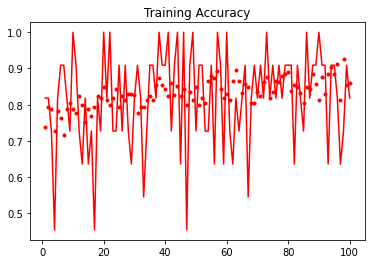

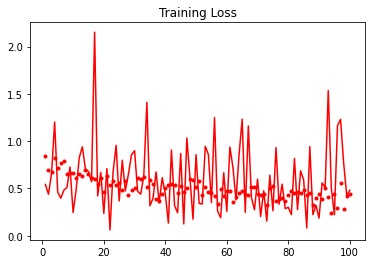

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()